In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

# train data 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

# Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any') 

# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# white space 데이터를 empty value로 변경, 빈 행은 제거
train_data['document'] = train_data['document'].str.replace('^ +', "") 
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')

# test data 전처리
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

C:\Users\yejin.hwang\AppData\Local\Programs\Python\Python37\py37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\yejin.hwang\AppData\Local\Programs\Python\Python37\py37\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\yejin.hwang\AppData\Local\Programs\Python\Python37\py37\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\yejin.hwang\AppData\Local\Programs\Python\Python37\py37\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The default value of regex will change from True to False in a future version.


In [4]:
okt = Okt()

# 불용어 지정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# train data 토큰화
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)
    
# test data 토큰화
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 48852/48852 [01:40<00:00, 484.37it/s]


In [5]:
# 정수인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        #rare_freq = rare_freq + value

vocab_size = total_cnt - rare_cnt + 1       

# vocabsize를 3회 이상인 단어 집합 크기로 제한해서 3회 미만은 자동으로 tokenizer에 포함되지 않도록 함
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# y 데이터는 별도로 지정
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])


# 빈도수 낮은 단어를 삭제하면서 생긴 빈 샘플 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)


max_len = 30
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

C:\Users\yejin.hwang\AppData\Local\Programs\Python\Python37\py37\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


#### 1D CNN

In [7]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
# hyperparamter
embedding_dim = 64
dropout_ratio = 0.3
num_filters = 64
kernel_size = 5

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
1813/1815 [============================>.] - ETA: 0s - loss: 0.4145 - acc: 0.8096
Epoch 1: val_acc improved from -inf to 0.84394, saving model to best_model.h5
1815/1815 [==============================] - 21s 11ms/step - loss: 0.4145 - acc: 0.8096 - val_loss: 0.3612 - val_acc: 0.8439
Epoch 2/10
1813/1815 [============================>.] - ETA: 0s - loss: 0.3248 - acc: 0.8628
Epoch 2: val_acc improved from 0.84394 to 0.84649, saving model to best_model.h5
1815/1815 [==============================] - 27s 15ms/step - loss: 0.3248 - acc: 0.8628 - val_loss: 0.3567 - val_acc: 0.8465
Epoch 3/10
1814/1815 [============================>.] - ETA: 0s - loss: 0.2794 - acc: 0.8838
Epoch 3: val_acc did not improve from 0.84649
1815/1815 [==============================] - 26s 14ms/step - loss: 0.2794 - acc: 0.8838 - val_loss: 0.3669 - val_acc: 0.8452
Epoch 4/10
1813/1815 [============================>.] - ETA: 0s - loss: 0.2445 - acc: 0.9003
Epoch 4: val_acc did not improve from 0.84649
18

In [11]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 2s 1ms/step - loss: 0.4180 - acc: 0.8338

 테스트 정확도: 0.8338


#### Multi-Kernel 1D CNN
다양한 크기의 커널들을 혼합하여 사용     
functional API를 사용함

In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [16]:
#hyperparameter
embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 32
hidden_units = 128

# 입력층, embedding층 정의
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_ratio[0])(z)

# 3, 4, 5의 크기를 가지는 kernel을 각각 32개 사용하고, 이후 maxpooling 적용
conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)    # maxpooling을 적용한 각각의 결과를 conv_blocks에 저장

# 모든 maxpooling 결과를 concatenate
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 128)      2485248     ['input_2[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 30, 128)      0           ['embedding[0][0]']              
                                                                                                  
 conv1d_5 (Conv1D)              (None, 28, 32)       12320       ['dropout_6[0][0]']              
                                                                                            

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.2, verbose=2, callbacks=[es, mc])

Epoch 1/5

Epoch 1: val_acc improved from -inf to 0.83681, saving model to CNN_model.h5
1815/1815 - 56s - loss: 0.4396 - acc: 0.7953 - val_loss: 0.4252 - val_acc: 0.8368 - 56s/epoch - 31ms/step
Epoch 2/5

Epoch 2: val_acc improved from 0.83681 to 0.83746, saving model to CNN_model.h5
1815/1815 - 59s - loss: 0.3591 - acc: 0.8451 - val_loss: 0.4712 - val_acc: 0.8375 - 59s/epoch - 32ms/step
Epoch 3/5

Epoch 3: val_acc did not improve from 0.83746
1815/1815 - 67s - loss: 0.3299 - acc: 0.8599 - val_loss: 0.4988 - val_acc: 0.8373 - 67s/epoch - 37ms/step
Epoch 4/5

Epoch 4: val_acc did not improve from 0.83746
1815/1815 - 60s - loss: 0.3116 - acc: 0.8691 - val_loss: 0.5159 - val_acc: 0.8311 - 60s/epoch - 33ms/step
Epoch 5/5

Epoch 5: val_acc did not improve from 0.83746
1815/1815 - 64s - loss: 0.2929 - acc: 0.8774 - val_loss: 0.5174 - val_acc: 0.8235 - 64s/epoch - 35ms/step
Epoch 5: early stopping


In [20]:
loaded_model = load_model('CNN_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 3s 2ms/step - loss: 0.4732 - acc: 0.8328

 테스트 정확도: 0.8328


### Pre-trained 워드 임베딩을 이용한 의도 분류

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [2]:
# 의도 데이터 다운로드 (텍스트가 담고 있는 의도를 파악해서 분류하는 것이 목표!)
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_train_data.csv", filename="intent_train_data.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_test_data.csv", filename="intent_test_data.csv")

train_data = pd.read_csv('intent_train_data.csv')
test_data = pd.read_csv('intent_test_data.csv')

In [3]:
train_data.head()

,intent,label
0,add another song to the cita rom ntica playlist,AddToPlaylist
1,add clem burke in my playlist pre party r b jams,AddToPlaylist
2,add live from aragon ballroom to trapeo,AddToPlaylist
3,add unite and win to my night out,AddToPlaylist
4,add track to my digster future hits,AddToPlaylist


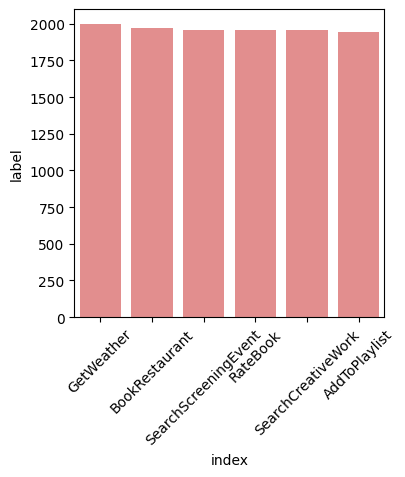

In [15]:
# label 확인
import seaborn as sns
temp = pd.DataFrame(train_data['label'].value_counts()).reset_index(drop=False)
plt.figure(figsize=(4,4))
sns.barplot(x='index', y='label', data=temp, color="lightcoral")
plt.xticks(rotation=45);

In [5]:
# 데이터 및 레이블을 리스트로 저장
intent_train = train_data['intent'].tolist()
label_train = train_data['label'].tolist()
intent_test = test_data['intent'].tolist()
label_test = test_data['label'].tolist()

print('훈련용 문장의 수 :', len(intent_train))
print('훈련용 레이블의 수 :', len(label_train))
print('테스트용 문장의 수 :', len(intent_test))
print('테스트용 레이블의 수 :', len(label_test))

훈련용 문장의 수 : 11784
훈련용 레이블의 수 : 11784
테스트용 문장의 수 : 600
테스트용 레이블의 수 : 600


In [16]:
# 레이블을 정수로 인코딩 -> scikit learn의 LabelEncoder 이용
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(label_train)

label_train = idx_encode.transform(label_train) # 주어진 고유한 정수로 변환
label_test = idx_encode.transform(label_test) # 고유한 정수로 변환

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print('레이블과 정수의 맵핑 관계 :',label_idx)

레이블과 정수의 맵핑 관계 : {'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}


In [17]:
# data 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)
sequences = tokenizer.texts_to_sequences(intent_train)
sequences[:5] # 상위 5개 샘플 출력

[[11, 191, 61, 4, 1, 4013, 1141, 1572, 15],
 [11, 2624, 1573, 3, 14, 15, 939, 82, 256, 188, 548],
 [11, 187, 42, 2625, 4014, 4, 1968],
 [11, 2626, 22, 2627, 4, 14, 192, 27],
 [11, 92, 4, 14, 651, 520, 195]]

In [18]:
# 단어 집합의 크기 확인
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 9870


문장의 최대 길이 : 35
문장의 평균 길이 : 9.364392396469789


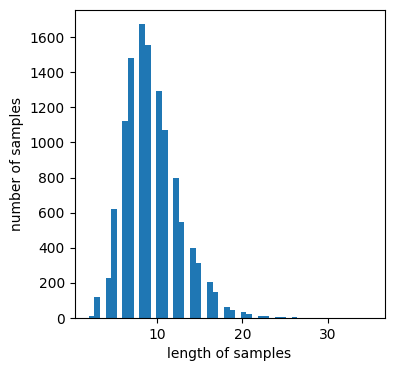

In [20]:
# 데이터의 길이 및 최대 길이 확인
print('문장의 최대 길이 :',max(len(l) for l in sequences))
print('문장의 평균 길이 :',sum(map(len, sequences))/len(sequences))
plt.figure(figsize=(4, 4))
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
# 모든 훈련 데이터를 최대 길이에 맞춰 padding
max_len = 35
intent_train = pad_sequences(sequences, maxlen = max_len)

In [23]:
# label: 원핫인코딩 수행(다중 분류를 수행하기 위해)
label_train = to_categorical(np.asarray(label_train))
label_train.shape

(11784, 6)

In [24]:
intent_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,   11,  191,   61,    4,    1, 4013, 1141,
       1572,   15])

In [29]:
#validation set 만들기

# 현재 데이터가 레이블별로 순서대로 나열되어 있으므로, 
# random number를 통해 train set의 순서를 섞고 이후에 validation set을 생성
indices = np.arange(intent_train.shape[0])
np.random.shuffle(indices)   # indices의 숫자를 random하게 섞어줌

intent_train = intent_train[indices]
label_train = label_train[indices]

n_of_val = int(0.1 * intent_train.shape[0])

X_train = intent_train[:-n_of_val]  # 뒤에 n_of_val개만큼 남기고 slicing
y_train = label_train[:-n_of_val]
X_val = intent_train[-n_of_val:]
y_val = label_train[-n_of_val:]
X_test = intent_test
y_test = label_test

In [30]:
print('훈련 데이터의 크기(shape):', X_train.shape)
print('검증 데이터의 크기(shape):', X_val.shape)
print('훈련 데이터 레이블의 크기(shape):', y_train.shape)
print('검증 데이터 레이블의 크기(shape):', y_val.shape)
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 데이터 레이블의 개수 :', len(y_test))

훈련 데이터의 크기(shape): (10606, 35)
검증 데이터의 크기(shape): (1178, 35)
훈련 데이터 레이블의 크기(shape): (10606, 6)
검증 데이터 레이블의 크기(shape): (1178, 6)
테스트 데이터의 개수 : 600
테스트 데이터 레이블의 개수 : 600


In [28]:
a = [3, 6, 5, 4, 3, 2, 0, 9, 22, 4]
a[:-3]

[3, 6, 5, 4, 3, 2, 0]

### 사전 훈련된 워드 임베딩 사용
훈련 데이터가 적은 상황일 경우 keras의 Embedding()으로 최적의 임베딩 벡터값을 얻는 것이 쉽지 않으므로,      
보다 많은 데이터로 이미 훈련된 Word2Vec이나 GloVe 등 이미 학습되어 있는 임베딩 벡터를 사용하는 것이 성능 개선의 포인트가 될 수 있다.         
- GloVe: 스탠포드 대학교에서 제공하는 임베딩            
    - 다운로드 링크: http://nlp.stanford.edu/data/glove.6B.zip           
- Word2Vec: 구글에서 사전 훈련한 임베딩
    - 다운로드 링크: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM

In [35]:
#!pip install wget
import wget
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
wget.download(url)

100% [......................................................................] 862182613 / 862182613

'glove.6B.zip'

In [37]:
#!pip install zipfile
import zipfile

path_to_zip_file = './glove.6B.zip'
directory_to_extract_to = './glove'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [38]:
# 임베딩 벡터 로드
embedding_dict = dict()
f = open(os.path.join('./glove/glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [39]:
# 예시 단어: respectable 의 임베딩 벡터값과 차원
print(embedding_dict['respectable'])
print(len(embedding_dict['respectable']))

[-0.049773   0.19903    0.10585    0.1391    -0.32395    0.44053
  0.3947    -0.22805   -0.25793    0.49768    0.15384   -0.08831
  0.0782    -0.8299    -0.037788   0.16772   -0.45197   -0.17085
  0.74756    0.98256    0.81872    0.28507    0.16178   -0.48626
 -0.006265  -0.92469   -0.30625   -0.067318  -0.046762  -0.76291
 -0.0025264 -0.018795   0.12882   -0.52457    0.3586     0.43119
 -0.89477   -0.057421  -0.53724    0.25587    0.55195    0.44698
 -0.24252    0.29946    0.25776   -0.8717     0.68426   -0.05688
 -0.1848    -0.59352   -0.11227   -0.57692   -0.013593   0.18488
 -0.32507   -0.90171    0.17672    0.075601   0.54896   -0.21488
 -0.54018   -0.45882   -0.79536    0.26331    0.18879   -0.16363
  0.3975     0.1099     0.1164    -0.083499   0.50159    0.35802
  0.25677    0.088546   0.42108    0.28674   -0.71285   -0.82915
  0.15297   -0.82712    0.022112   1.067     -0.31776    0.1211
 -0.069755  -0.61327    0.27308   -0.42638   -0.085084  -0.17694
 -0.0090944  0.1109     0.

In [41]:
# pre-trained 임베딩 벡터의 차원에 맞는 임베딩 테이블 생성
# -> 행: vocab_size, 열: 100
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
print('임베딩 테이블의 크기(shape) :',np.shape(embedding_matrix))

임베딩 테이블의 크기(shape) : (9870, 100)


In [45]:
# 훈련 데이터를 통해 만든 단어집합 내 단어와 pre-trained 워드 임베딩 벡터의 값을 맵핑해서 임베딩 테이블에 저장
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:  # train data에 대한 단어 집합 내 단어가 임베딩 벡터에도 있을 경우 맵핑
        embedding_matrix[i] = embedding_vector

#### 1D CNN을 이용한 의도분류

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate

kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for size in kernel_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=size,
                         padding="valid",
                         activation="relu",
                         strides=1)(output)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)
model_output = Dense(len(label_idx), activation='softmax')(output)
model = Model(model_input, model_output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 35, 100)      987000      ['input_2[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 34, 512)      102912      ['embedding_1[0][0]']            
                                                                                                  
 conv1d_3 (Conv1D)              (None, 33, 512)      154112      ['embedding_1[0][0]']            
                                                                                            

In [49]:
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          validation_data=(X_val, y_val))

Epoch 1/10
166/166 [==============================] - 7s 39ms/step - loss: 0.1897 - acc: 0.9397 - val_loss: 0.0654 - val_acc: 0.9805
Epoch 2/10
166/166 [==============================] - 7s 44ms/step - loss: 0.0455 - acc: 0.9863 - val_loss: 0.0600 - val_acc: 0.9779
Epoch 3/10
166/166 [==============================] - 8s 48ms/step - loss: 0.0255 - acc: 0.9930 - val_loss: 0.0556 - val_acc: 0.9839
Epoch 4/10
166/166 [==============================] - 8s 47ms/step - loss: 0.0186 - acc: 0.9944 - val_loss: 0.0514 - val_acc: 0.9830
Epoch 5/10
166/166 [==============================] - 8s 46ms/step - loss: 0.0118 - acc: 0.9968 - val_loss: 0.0660 - val_acc: 0.9779
Epoch 6/10
166/166 [==============================] - 7s 45ms/step - loss: 0.0109 - acc: 0.9975 - val_loss: 0.0567 - val_acc: 0.9847
Epoch 7/10
166/166 [==============================] - 7s 45ms/step - loss: 0.0092 - acc: 0.9972 - val_loss: 0.0554 - val_acc: 0.9839
Epoch 8/10
166/166 [==============================] - 7s 44ms/step - 

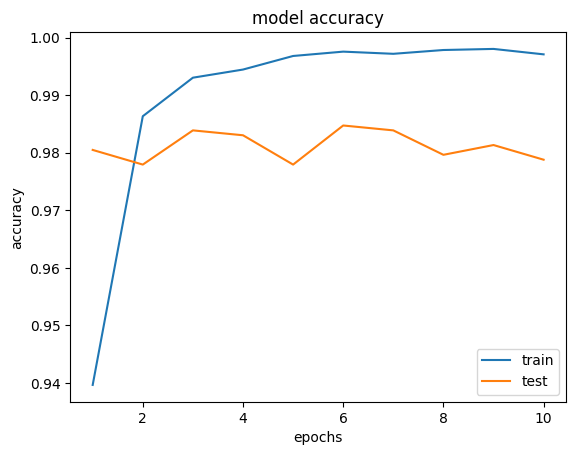

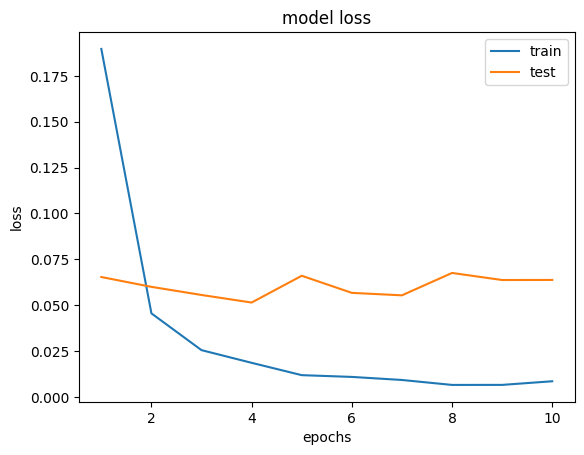

In [50]:
# 정확도 및 loss 변화 시각화
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [51]:
# 테스트 데이터 예측
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=-1) # 예측을 정수 시퀀스로 변환

19/19 [==============================] - 0s 8ms/step


In [55]:
print('정확도(Accuracy) : ', sum(y_predicted == y_test) / len(y_test))

정확도(Accuracy) :  0.99
